# Tutorial

import DeepQuantum以及相关的库。

In [1]:
import deepquantum as dq
import torch
import torch.nn as nn
import numpy as np

## 基本的量子门

所有的Gate都是Operation的子类，都有布尔变量`den_mat`和`tsr_mode`。

参数`den_mat`表示这个操作是处理密度矩阵，还是态矢。

参数`tsr_mode`表示这个操作的输入输出是张量态（形状为（batch, 2, ..., 2）的tensor），还是态矢或密度矩阵。

我们利用`QubitState`准备一个单比特量子态（默认为'zeros'表示全0态，此外，有'equal'表示等权叠加态，'ghz'表示GHZ态），其数据是torch的tensor，存在属性`state`中。

In [2]:
qstate = dq.QubitState(nqubit=1, state=[0,1])
state1 = qstate.state
print(state1)

tensor([[0.+0.j],
        [1.+0.j]])


实例化一个单比特量子门，可以从`matrix`属性获得量子门的基础表示（相对于指定任意控制位的量子门而言）。

In [3]:
x = dq.PauliX()
x.matrix

tensor([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]])

用量子门对量子态进行操作，既可以通过手动的矩阵乘法，也可以通过把量子门直接作用在量子态上。

In [4]:
print(x.matrix @ state1)
print(x(state1))

tensor([[1.+0.j],
        [0.+0.j]])
tensor([[1.+0.j],
        [0.+0.j]])


我们再看带参数的量子门的例子。

In [5]:
rx = dq.Rx(torch.pi/2)
print(rx.matrix @ state1)
print(rx(state1))

tensor([[0.0000-0.7071j],
        [0.7071+0.0000j]])
tensor([[0.0000-0.7071j],
        [0.7071+0.0000j]])


可以利用`get_matrix()`获取带参数量子门的计算过程。

In [6]:
rx.get_matrix(torch.pi) @ state1

tensor([[ 0.0000e+00-1.j],
        [-4.3711e-08+0.j]])

注意`matrix`只是纯粹的矩阵表示，因此当需要记录计算图来求参数的梯度时，必须使用`update_matrix()`或`get_matrix()`，区别在于前者使用该量子门本身的参数，而后者需要输入参数，适用于外部的指定参数。

In [7]:
rx = dq.Rx(torch.pi/2, requires_grad=True)
theta = nn.Parameter(torch.tensor(torch.pi/2))
print(rx.matrix)
print(rx.update_matrix())
print(rx.get_matrix(theta))

tensor([[0.7071+0.0000j, -0.0000-0.7071j],
        [-0.0000-0.7071j, 0.7071+0.0000j]])
tensor([[0.7071+0.0000j, -0.0000-0.7071j],
        [-0.0000-0.7071j, 0.7071+0.0000j]], grad_fn=<ReshapeAliasBackward0>)
tensor([[0.7071+0.0000j, -0.0000-0.7071j],
        [-0.0000-0.7071j, 0.7071+0.0000j]], grad_fn=<ReshapeAliasBackward0>)


In [8]:
print(rx.matrix @ state1)
print(rx.update_matrix() @ state1)
print(rx.get_matrix(theta) @ state1)
print(rx(state1))

tensor([[0.0000-0.7071j],
        [0.7071+0.0000j]])
tensor([[0.0000-0.7071j],
        [0.7071+0.0000j]], grad_fn=<MmBackward0>)
tensor([[0.0000-0.7071j],
        [0.7071+0.0000j]], grad_fn=<MmBackward0>)
tensor([[0.0000-0.7071j],
        [0.7071+0.0000j]], grad_fn=<SqueezeBackward1>)


处理多比特量子态时，量子门的`nqubit`需要与量子态的一致，用`wires`来指定量子门作用于哪些线路上。同样，既可以通过`get_unitary()`得到完整的酉矩阵后进行手动的矩阵乘法，也可以通过把量子门直接作用在量子态上。需要注意，前者的计算效率远低于后者。

In [9]:
state2 = dq.QubitState(nqubit=2, state=[0,0,0,1]).state
print(state2)
rx = dq.Rx(torch.pi/2, nqubit=2, wires=[1], requires_grad=True)
print(rx.get_unitary() @ state2)
print(rx(state2))

tensor([[0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [1.+0.j]])
tensor([[0.0000+0.0000j],
        [0.0000+0.0000j],
        [0.0000-0.7071j],
        [0.7071+0.0000j]], grad_fn=<MmBackward0>)
tensor([[0.0000+0.0000j],
        [0.0000+0.0000j],
        [0.0000-0.7071j],
        [0.7071+0.0000j]], grad_fn=<SqueezeBackward1>)


DeepQuantum中几乎所有的量子门都支持额外指定任意多的控制位（例外有`CNOT`、`Toffoli`、`Fredkin`等）。因此，同一个量子门可能会有不止一种调用方法。比如cnot和Toffoli可以用`PauliX`实现，Fredkin可以用`Swap`实现。

In [10]:
cx1 = dq.CNOT(wires=[0,1])
cx2 = dq.PauliX(nqubit=2, wires=[1], controls=[0])

ccx1 = dq.Toffoli(wires=[0,1,2])
ccx2 = dq.PauliX(nqubit=3, wires=[2], controls=[0,1])

cswap1 = dq.Fredkin(wires=[0,1,2])
cswap2 = dq.Swap(nqubit=3, wires=[1,2], controls=[0])

注意，它们的`matrix`是不同的。并且，前者的计算效率略高于后者。

In [11]:
print(cx1.matrix)
print(cx2.matrix)

print(ccx1.matrix)
print(ccx2.matrix)

print(cswap1.matrix)
print(cswap2.matrix)

tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])
tensor([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]])
tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])
tensor([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]])
tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0

后者可以用`get_unitary()`来检查。

In [12]:
print(cx2.get_unitary())
print(ccx2.get_unitary())
print(cswap2.get_unitary())

tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])
tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])
tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j,

用户还可以通过`UAnyGate`来封装任意酉矩阵。比如，把$4\times4$的酉矩阵作用在三比特量子态的后两个量子比特上，其中用`minmax`指定作用范围，需要和酉矩阵的大小匹配。

In [13]:
unitary = [[0, 0, 0, 1],
           [0, 0, 1, 0],
           [1, 0, 0, 0],
           [0, 1, 0, 0]]
u = dq.UAnyGate(unitary=unitary, nqubit=3, minmax=[1,2])
print(u.get_unitary())

tensor([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])


## 制备GHZ态

我们来实现一下制备GHZ态（$|\psi\rangle = \left(|000\rangle+|111\rangle\right)/\sqrt{2}$）这个经典的例子。

In [14]:
state3 = dq.QubitState(3).state
h = dq.Hadamard(nqubit=3, wires=0)
cx1 = dq.CNOT(nqubit=3, wires=[0,1])
cx2 = dq.CNOT(nqubit=3, wires=[0,2])
print(cx2(cx1(h(state3))))

tensor([[0.7071+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.7071+0.j]])


## 量子线路：QubitCircuit

量子线路是DeepQuantum的核心对象。通过`QubitCircuit`进行初始化，然后可以在实例对象上添加各种量子门，最后进行演化和测量。我们把上面这个例子用量子线路来实现。并且可以对线路进行可视化。

tensor([[0.7071+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.7071+0.j]])


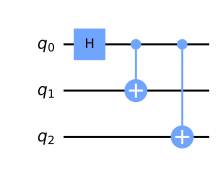

In [15]:
cir = dq.QubitCircuit(3)
cir.h(0)
cir.cnot(0, 1)
cir.cnot(0, 2)
print(cir())
cir.draw()

我们可以对线路进行测量，返回的结果是字典或者字典的列表，字典的key是比特串，value是对应测量到的次数，shots默认为1024。

{'111': 532, '000': 492}


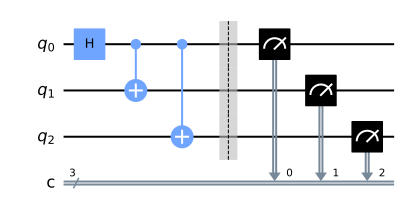

In [16]:
cir.barrier()
print(cir.measure())
cir.draw()

也可以设定采样次数、进行部分测量以及显示理想的概率。

{'00': (62, tensor(0.5000)), '11': (38, tensor(0.5000))}


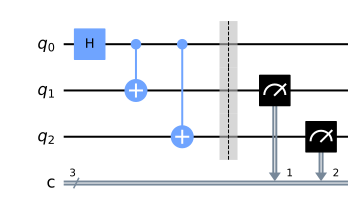

In [17]:
print(cir.measure(shots=100, wires=[1,2], with_prob=True))
cir.draw()

再来看一个对CNOT门实现分解的例子：$\text{CNOT}=e^{-i{\frac {\pi }{4}}}R_{y_{1}}(-\pi /2)R_{x_{1}}(-\pi /2)R_{x_{2}}(-\pi /2)R_{xx}(\pi /2)R_{y_{1}}(\pi /2)$

tensor([[ 1.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j, -1.7458e-08+0.j],
        [ 0.0000e+00+0.j,  1.0000e+00+0.j, -1.7458e-08+0.j,  0.0000e+00+0.j],
        [-1.7458e-08+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  1.0000e+00+0.j],
        [ 0.0000e+00+0.j, -1.7458e-08+0.j,  1.0000e+00+0.j,  0.0000e+00+0.j]])


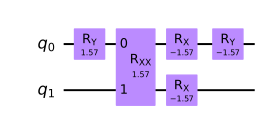

In [18]:
cir = dq.QubitCircuit(2)
cir.ry(0, torch.pi/2)
cir.rxx([0,1], torch.pi/2)
cir.rx(1, -torch.pi/2)
cir.rx(0, -torch.pi/2)
cir.ry(0, -torch.pi/2)
print(np.exp(-1j * np.pi / 4) * cir.get_unitary())
cir.draw()

CNOT、Toffoli、Fredkin也有不同的API去添加。

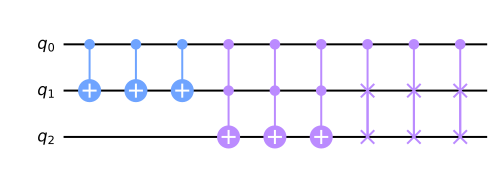

In [19]:
cir = dq.QubitCircuit(3)
cir.cnot(0, 1)
cir.cx(0, 1)
cir.x(1, 0)

cir.toffoli(0, 1, 2)
cir.ccx(0, 1, 2)
cir.x(2, [0,1])

cir.fredkin(0, 1, 2)
cir.cswap(0, 1, 2)
cir.swap([1,2], 0)

cir.draw()

## 参数化量子线路

DeepQuantum可以帮助用户很方便地实现参数化量子线路，从而进行量子机器学习。

`QubitCircuit`的实例中添加的带参数的量子门，如果没有指定输入参数，会自动初始化变分参数。

补充说明：如果指定了输入参数，那么输入参数会在量子门中被记录为buffer，从而保留其原来的性质。比如，参数不需要求梯度时，就会保持不变。又比如，参数是上一层神经网络的输出，那么在backward过程中就会记录梯度，但它的更新不是通过`QubitCircuit`而是上一层神经网络本身。

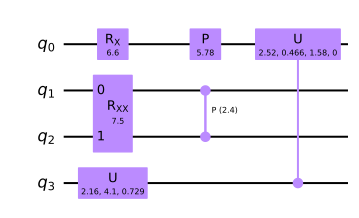

In [20]:
cir = dq.QubitCircuit(4)
cir.rx(0)
cir.rxx([1,2])
cir.u3(3)
cir.p(0)
cir.cu(3, 0)
cir.cp(1, 2)
cir.draw()


也可以直接添加一层量子门，并通过`wires`指定放置于哪几条线路。

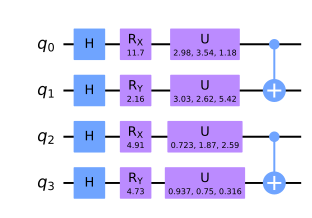

In [21]:
cir = dq.QubitCircuit(4)
cir.hlayer()
cir.rxlayer([0,2])
cir.rylayer([1,3])
cir.u3layer()
cir.cxlayer()
cir.draw()

`cnot_ring()`可以用`minmax`参数指定线路范围，`step`设定每一对control和target相隔的距离，`reverse`指定是否从大到小。

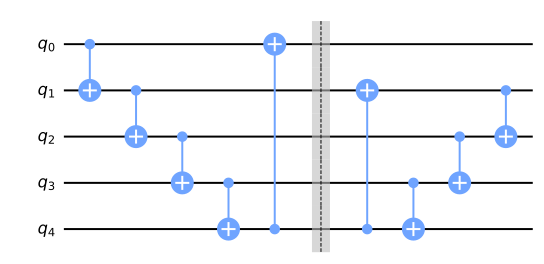

In [22]:
cir = dq.QubitCircuit(5)
cir.cnot_ring()
cir.barrier()
cir.cnot_ring(minmax=[1,4], step=3, reverse=True)
cir.draw()

### 振幅编码

下面我们展示一个振幅编码的例子，先准备一些数据。

In [23]:
nqubit = 4
batch = 2
data = torch.randn(batch, 2 ** nqubit)

然后构建量子线路，并通过`observable`指定测量线路和测量基底。测量线路和测量基底也可以使用列表形式的组合，如`wires=[0,1,2]`、`basis='xyz'`。

In [24]:
cir = dq.QubitCircuit(nqubit)
cir.rxlayer()
cir.cnot_ring()
cir.observable(wires=0, basis='z')

量子门和观测量分别被记录在`operators`和`observables`中。

In [25]:
print(cir)

QubitCircuit(
  (operators): Sequential(
    (0): RxLayer(
      (gates): Sequential(
        (0): Rx(wires=[0], theta=2.4975132942199707)
        (1): Rx(wires=[1], theta=3.552344560623169)
        (2): Rx(wires=[2], theta=7.044006824493408)
        (3): Rx(wires=[3], theta=0.7623158097267151)
      )
    )
    (1): CnotRing(
      (gates): Sequential(
        (0): CNOT(wires=[0, 1])
        (1): CNOT(wires=[1, 2])
        (2): CNOT(wires=[2, 3])
        (3): CNOT(wires=[3, 0])
      )
    )
  )
  (observables): ModuleList(
    (0): Observable(
      (gates): Sequential(
        (0): PauliZ(wires=[0])
      )
    )
  )
)


振幅编码会自动补0或者舍弃多余的数据，以及进行归一化。

通过线路的`forward()`得到末态，`forward()`有`data`和`state`两个参数，分别对应放入量子门的数据，以及线路作用的初态，即分别对应角度编码和振幅编码。

测量期望，输出的形状为(batch, 观测量的数量)。

In [26]:
state = cir.amplitude_encoding(data)
state = cir(state=state)
exp = cir.expectation()
print(state.shape)
print(state.norm(dim=-2))
print(exp)

torch.Size([2, 16, 1])
tensor([[1.],
        [1.]], grad_fn=<LinalgVectorNormBackward0>)
tensor([[-0.1803],
        [-0.0892]], grad_fn=<StackBackward0>)


### 角度编码

角度编码只需要对相应的Gate或Layer指定`encode=True`，会自动将数据的特征依次加入编码层，多余的会被舍弃。

In [27]:
nqubit = 4
batch = 2
data = torch.sin(torch.tensor(list(range(batch * nqubit)))).reshape(batch, nqubit)
print(data)

tensor([[ 0.0000,  0.8415,  0.9093,  0.1411],
        [-0.7568, -0.9589, -0.2794,  0.6570]])


这次我们对每条线路都进行一次测量。

In [28]:
cir = dq.QubitCircuit(nqubit)
cir.hlayer()
cir.rxlayer(encode=True)
cir.cnot_ring()
for i in range(nqubit):
    cir.observable(wires=i)
state = cir(data)
exp = cir.expectation()
print(state.shape)
print(state.norm(dim=-2))
print(exp)

torch.Size([2, 16, 1])
tensor([[1.0000],
        [1.0000]])
tensor([[1.4901e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.4506e-09, 7.4506e-09, 0.0000e+00, 0.0000e+00]])


`QubitCircuit`支持data re-uploading，只需要初始化时指定`reupload=True`，数据就会被循环地放入线路中。

补充说明：`encode`只能针对一条一维的数据，线路对batch的支持是通过`torch.vmap`，并且计算完一次前向过程会自动初始化`encoders`，因为量子门无法保存多组参数。

In [29]:
cir = dq.QubitCircuit(nqubit, reupload=True)
cir.rxlayer(encode=True)
cir.cnot_ring()
cir.rxlayer(encode=True)
cir.cnot_ring()
cir.encode(data[0])
print(cir)

QubitCircuit(
  (operators): Sequential(
    (0): RxLayer(
      (gates): Sequential(
        (0): Rx(wires=[0], theta=tensor([0.]))
        (1): Rx(wires=[1], theta=tensor([0.8415]))
        (2): Rx(wires=[2], theta=tensor([0.9093]))
        (3): Rx(wires=[3], theta=tensor([0.1411]))
      )
    )
    (1): CnotRing(
      (gates): Sequential(
        (0): CNOT(wires=[0, 1])
        (1): CNOT(wires=[1, 2])
        (2): CNOT(wires=[2, 3])
        (3): CNOT(wires=[3, 0])
      )
    )
    (2): RxLayer(
      (gates): Sequential(
        (0): Rx(wires=[0], theta=tensor([0.]))
        (1): Rx(wires=[1], theta=tensor([0.8415]))
        (2): Rx(wires=[2], theta=tensor([0.9093]))
        (3): Rx(wires=[3], theta=tensor([0.1411]))
      )
    )
    (3): CnotRing(
      (gates): Sequential(
        (0): CNOT(wires=[0, 1])
        (1): CNOT(wires=[1, 2])
        (2): CNOT(wires=[2, 3])
        (3): CNOT(wires=[3, 0])
      )
    )
  )
  (observables): ModuleList()
)


### 混合量子-经典模型

DeepQuantum基于PyTorch，能够方便自然地实现量子模型和经典模型的混合计算。

In [30]:
class Net(nn.Module):
    def __init__(self, dim_in, nqubit) -> None:
        super().__init__()
        self.fc = nn.Linear(dim_in, nqubit)
        self.cir = self.circuit(nqubit)

    def circuit(self, nqubit):
        cir = dq.QubitCircuit(nqubit)
        cir.hlayer()
        cir.rxlayer(encode=True)
        cir.cnot_ring()
        for i in range(nqubit):
            cir.observable(wires=i)
        return cir
    
    def forward(self, x):
        x = torch.arctan(self.fc(x))
        self.cir(x)
        exp = self.cir.expectation()
        return exp

nqubit = 4
batch = 2
nfeat = 8
x = torch.sin(torch.tensor(list(range(batch * nfeat)))).reshape(batch, nfeat)
net = Net(nfeat, nqubit)
y = net(x)
print(net.state_dict())
print('y', y)

OrderedDict([('fc.weight', tensor([[-0.0471,  0.2069,  0.2709,  0.1491, -0.3424, -0.1332,  0.1634, -0.3425],
        [-0.2075,  0.2382,  0.2312, -0.1837,  0.0663, -0.3311,  0.2698, -0.1313],
        [-0.1981, -0.0585,  0.0302,  0.0370, -0.0251, -0.0460, -0.1088, -0.1174],
        [ 0.1519, -0.1392, -0.0941,  0.2542,  0.1750,  0.1514,  0.2043, -0.3521]])), ('fc.bias', tensor([ 0.1420,  0.2372, -0.0617,  0.2729])), ('cir.init_state', tensor([[1.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j]])), ('cir.operators.0.gates.0.matrix', tensor([[ 0.7071+0.j,  0.7071+0.j],
        [ 0.7071+0.j, -0.7071+0.j]])), ('cir.operators.0.gates.1.matrix', tensor([[ 0.7071+0.j,  0.7071+0.j],
        [ 0.7071+0.j, -0.7071+0.j]])), ('cir.operators.0.gates.2.matrix', tensor([[ 0.7071+0

### 线路拼接以及更灵活地使用数据

In [31]:
nqubit = 2
batch = 2
data1 = torch.sin(torch.tensor(list(range(batch * nqubit)))).reshape(batch, nqubit)
data2 = torch.cos(torch.tensor(list(range(batch * nqubit)))).reshape(batch, nqubit)
cir1 = dq.QubitCircuit(nqubit)
cir1.rxlayer(encode=True)
cir2 = dq.QubitCircuit(nqubit)
cir2.rylayer(encode=True)
cir3 = dq.QubitCircuit(nqubit)
cir3.rzlayer()

通过线路加法来共享变分参数。

注意，不建议对encoder部分进行复杂的线路加法来共享数据，因为需要保证数据的顺序与encoders完全一致。一旦出现错位，由于共享了encoders，会造成全局的影响。

In [32]:
data = torch.cat([data1, data2], dim=-1)
cir = cir1 + cir3 + cir2 + cir3
cir.observable(0)
cir.encode(data[0])
print(cir)
cir(data)
print(cir.expectation())

QubitCircuit(
  (operators): Sequential(
    (0): RxLayer(
      (gates): Sequential(
        (0): Rx(wires=[0], theta=tensor([0.]))
        (1): Rx(wires=[1], theta=tensor([0.8415]))
      )
    )
    (1): RzLayer(
      (gates): Sequential(
        (0): Rz(wires=[0], theta=9.046151161193848)
        (1): Rz(wires=[1], theta=7.990583896636963)
      )
    )
    (2): RyLayer(
      (gates): Sequential(
        (0): Ry(wires=[0], theta=tensor([1.]))
        (1): Ry(wires=[1], theta=tensor([0.5403]))
      )
    )
    (3): RzLayer(
      (gates): Sequential(
        (0): Rz(wires=[0], theta=9.046151161193848)
        (1): Rz(wires=[1], theta=7.990583896636963)
      )
    )
  )
  (observables): ModuleList(
    (0): Observable(
      (gates): Sequential(
        (0): PauliZ(wires=[0])
      )
    )
  )
)
tensor([[0.5403],
        [0.6798]], grad_fn=<StackBackward0>)


上面的结果也可以由多个线路的分段演化得到。

In [33]:
state = cir1(data1)
state = cir3(state=state)
state = cir2(data2, state=state)
state = cir3(state=state)
cir3.reset_observable()
cir3.observable(0)
print(cir3.expectation())

tensor([[0.5403],
        [0.6798]], grad_fn=<StackBackward0>)


这种方式当然就可以更灵活地使用数据。

In [34]:
state = cir1(data1)
state = cir2(data2, state=state)
state = cir3(state=state)
state = cir1(data2, state=state)
state = cir2(data1, state=state)
cir2.reset_observable()
cir2.observable(0)
print(cir2.expectation())

tensor([[ 0.5537],
        [-0.2558]], grad_fn=<StackBackward0>)
